# Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
import re
import math
from IPython.display import display_html
from itertools import chain,cycle
from scipy import stats
from scipy.stats import mannwhitneyu
from pandas.core.common import flatten

# Function Definitions

In [2]:
def replace_str_list(string_list):
    '''
    INPUT -  string_list - string-formatted list enclosed in {} and separated by ,
    OUTPUT - List of strings
    '''
    lst = string_list.replace('{', '').replace('}', '').replace('"', '').split(',')
    if lst == '':
        return None
    else:
        return lst

In [3]:
def highlight_significant(row): 
    '''
    INPUT - row - row of dataframe with a 'p-value' column
    OUTPUT -  CSS highlighting of dataframe row with significant p-value 
    '''
    highlight = 'background-color: lightcoral;'
    default = ''
    
    # Only highlight p-values of rows where p-value is significant
    if row['p-value'] <= 0.05:
        return [highlight]
    else:
        return [default]

In [4]:
def currency_to_float(price_dollars):
    '''
    INPUT - price_dollars - price as srting in Dollars including currency
    OUTPUT - price as a float rounded to 2 digits
            
    '''
    return round(float(re.sub(r'[\$,]', '', price_dollars)),2)

In [5]:
def get_mean_nan(df):
    '''
    INPUT - df - dataframe with data
    OUTPUT - column_perc_nan - percentage of null values in each column of the dataframe 
    '''
    column_perc_nan = (df.isnull().mean()*100).to_frame().reset_index()
    column_perc_nan.columns = ['attribute', 'percentage']
    return column_perc_nan

In [6]:
def split_dictionary_col(df, col_name):
    '''
    INPUT - df - dataframe containning string-formatted list column
          - col_name - string-formatted list column to be unpacked into different binary columns
    OUTPUT -  dataframe with row values converted to binary columns   
    '''
    temp_col = 'list_' + col_name
    # Transform string-formatted list to a list of stings
    df[temp_col] = df[col_name].apply(lambda d: replace_str_list(d))
    # Get the unique values by flattening all lists and transforming to a set 
    unique_vals = set(flatten(df[temp_col].to_list()))
    unique_vals = [v for v in unique_vals]
    
    # Remove empty strings from list
    if '' in unique_vals:
        unique_vals.remove('')
    
    for value in unique_vals:
        cat_col_name = 'has_' + value.lower().replace(' ', '_')
        # Create new columns in dataframe with binary encoding of list values
        df[cat_col_name] = df[temp_col].apply(lambda l: 1 if value in l else 0)
        
    df.drop(columns=[temp_col], inplace=True)

In [7]:
def get_percentage_nan(df_seattle, df_boston):
    '''
    INPUT - df_seattle - dataframe of Seatlle listings/calendar data
          - df_boston - dataframe of Boston listings/calendar data
    OUTPUT - concatenated dataframe containing the percentage of NAN values in the input dataframe
    '''
    column_perc_nan_seattle = get_mean_nan(df_seattle)
    column_perc_nan_boston = get_mean_nan(df_boston)

    # Add a column denoting the city, this necessary for the argument 'hue' in seaborn
    column_perc_nan_seattle['city'] = 'Seattle'
    column_perc_nan_boston['city'] = 'Boston'

    return pd.concat([column_perc_nan_seattle, column_perc_nan_boston]) 

In [8]:
def plot_nan_column_percentages(df, datasource):
    '''
    INPUT - df - dataframe containning percentages of NAN values in listings/calendar dataframes
          - datasource - name of the data source (listing, dataframe)
    '''
    sns.set(rc={'figure.figsize':(10,5)})
    
    graph = sns.barplot(x="attribute", y="percentage", hue="city", data=df[df['percentage']>0], palette="mako")  
    graph.set(title='Percentage of missing values per column in '+ datasource)
    graph.set_xticklabels(graph.get_xticklabels(), rotation=90)

In [9]:
def get_top_corr_columns(top_nr, df, all_columns):
    '''
    INPUT - top_nr - number of top correlation values to return
          - df - dataframe to calculate the column correlations for
          - all_columns - column names to take into account in the Pearson correlation analysis
    OUTPUT - sorted list of top_nr correlating columns with the price column
    '''
    correlations = np.corrcoef(df[all_columns].values.T)
    corr_price = correlations[0]
    
    # Get the indices of the top_nr highest correlation values (absolute value) with the variable 'price'
    sorted_indices = np.argsort(np.absolute(corr_price))[-(top_nr + 1):]
    selected_columns = [all_columns[i] for i in  sorted_indices]
    return sorted(selected_columns)

In [10]:
def display_side_by_side(*args, titles = cycle([''])):
    '''
    INPUT - args - dataframes to be displayed as side-by-side tables
          - titles - tittles of the tables to be drawn
    '''
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [11]:
def extract_date(df):
    '''
    INPUT - df - dataframe containing a string-formatted 'date' column to be converted to datetime and extracted into 'month' and 'year' columns
    '''
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
    df['month'] = df['date'].apply(lambda d: d.month)
    df['year'] = df['date'].apply(lambda d: d.year)

In [12]:
def draw_holiday(day_of_year, description, graph, color, position):
    '''
    INPUT - day_of_year - day of the year
          - description - name of the holiday
          - graph - graph variable to draw to
          - color - color of the axis to be drawn
          - position - position of the axis to be drawn, value in {top, bottom}
    '''
    # Add vertical line for each holiday 
    plt.axvline(day_of_year, color=color, linestyle='--')
    
    # Adjust position of text
    if position == 'top':
        position_y = 0.8
    else:
        position_y = 0.08
    
    # Add name of each holiday
    graph.text(day_of_year -3, position_y, description , fontsize=9, rotation=90, color=color)

In [13]:
def col_to_binary(df, column, unique_values):
    '''
    INPUT - df - dataframe containing a list column to unpack into binary columns
          - column - single list column to unpack into binary columns
          - unique_values - unique values of all possible values in 'column'
    OUTPUT -       
    '''
    for value in unique_values:
        # Return 1 if unique value is in list column, otherwise 0
        df[column + '_' + value] = df[column].apply(lambda l: 1 if l == value else 0)

# Data Cleaning

In [14]:
# Load listings and calendar data from .csv files
df_listing_seattle = pd.read_csv('airbnb_seattle/listings.csv')
df_listing_boston = pd.read_csv('airbnb_boston/listings.csv')

df_calendar_seattle = pd.read_csv('airbnb_seattle/calendar.csv')
df_calendar_boston = pd.read_csv('airbnb_boston/calendar.csv')

print('Seattle listings :', df_listing_seattle.shape, 'Boston listings: ', df_listing_boston.shape)
print('Seattle calendar :', df_calendar_seattle.shape, 'Boston calendar: ', df_calendar_boston.shape)

Seattle listings : (3818, 92) Boston listings:  (3585, 95)
Seattle calendar : (1393570, 4) Boston calendar:  (1308890, 4)


In [15]:
# Load list of relevant holidays in the states of Washington and Massachusetts for the years 2016-2017 according to periods in calendar.csv
holidays_seattle = pd.read_csv('holidays_seattle/holidays_seattle.csv')
holidays_boston = pd.read_csv('holidays_boston/holidays_boston.csv')

In [16]:
# Get common columns between the Seattle and the Boston listing datasets and keep only these common columns
listing_intersection = list(set(df_listing_seattle.columns) & set(df_listing_seattle.columns))
df_listing_seattle = df_listing_seattle[listing_intersection]
df_listing_boston = df_listing_boston[listing_intersection]

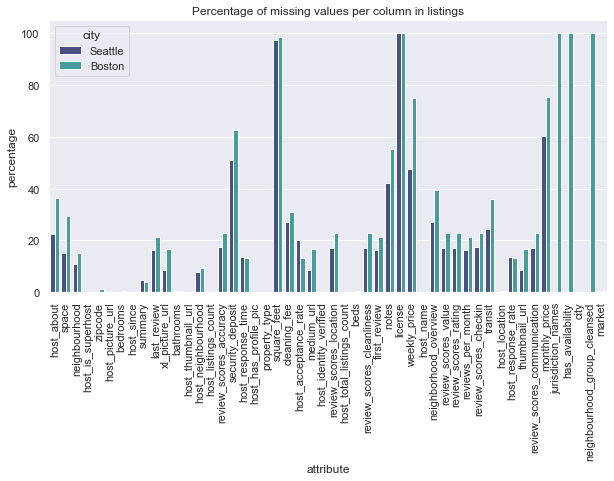

In [17]:
# Plot the percentage of NAN vlaues in the listings dataset columns (columns that are 100% filled are not depicted)
listings_nan_cities = get_percentage_nan(df_listing_seattle, df_listing_boston)
plot_nan_column_percentages(listings_nan_cities, 'listings')
plt.savefig('figures/nan_listings_columns.pdf', bbox_inches='tight')

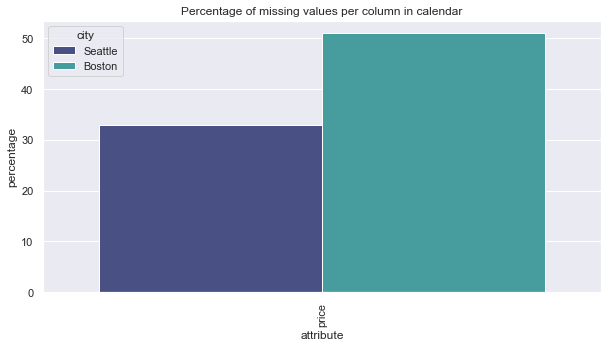

In [18]:
# Plot the percentage of NAN vlaues in the calendar dataset columns (columns that are 100% filled are not depicted)
calendar_nan_cities = get_percentage_nan(df_calendar_seattle, df_calendar_boston)
plot_nan_column_percentages(calendar_nan_cities, 'calendar')
plt.savefig('figures/nan_calendar_columns.pdf')

In [19]:
# Drop columns with more than 60% of values missing 
col_to_drop_listings = listings_nan_cities[listings_nan_cities['percentage'] > 60]['attribute'].to_list()

# We should keep the security deposit column since a NAN value means the host does not require a deposit
if 'security_deposit' in col_to_drop_listings:
    col_to_drop_listings.remove('security_deposit')
    
df_listing_seattle.drop(col_to_drop_listings, axis=1)
df_listing_boston.drop(col_to_drop_listings, axis=1)

,experiences_offered,host_about,street,country,amenities,space,neighbourhood,host_is_superhost,availability_365,zipcode,...,host_location,accommodates,host_response_rate,room_type,thumbnail_url,review_scores_communication,market,calendar_last_scraped,requires_license,extra_people
0,none,We are country and city connecting in our deck...,"Birch Street, Boston, MA 02131, United States",United States,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",The house has an open and cozy feel at the sam...,Roslindale,f,0,02131,...,"Boston, Massachusetts, United States",4,NaN,Entire home/apt,https://a2.muscache.com/im/pictures/c0842db1-e...,NaN,Boston,2016-09-06,f,$0.00
1,none,I live in Boston and I like to travel and have...,"Pinehurst Street, Boston, MA 02131, United States",United States,"{TV,Internet,""Wireless Internet"",""Air Conditio...",Small but cozy and quite room with a full size...,Roslindale,f,359,02131,...,"Boston, Massachusetts, United States",2,100%,Private room,https://a1.muscache.com/im/pictures/39327812/d...,10.0,Boston,2016-09-06,f,$0.00
2,none,"I am a middle-aged, single male with a wide ra...","Ardale St., Boston, MA 02131, United States",United States,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...","Come stay with a friendly, middle-aged guy in ...",Roslindale,t,319,02131,...,"Boston, Massachusetts, United States",2,100%,Private room,https://a2.muscache.com/im/pictures/6ae8335d-9...,10.0,Boston,2016-09-06,f,$20.00
3,none,My husband and I live on the property. He’s a...,"Boston, MA, United States",United States,"{TV,Internet,""Wireless Internet"",""Air Conditio...",Most places you find in Boston are small howev...,NaN,f,98,NaN,...,"Boston, Massachusetts, United States",4,100%,Private room,https://a2.muscache.com/im/pictures/39764190-1...,10.0,Boston,2016-09-06,f,$25.00
4,none,I work full time for a public school district....,"Durnell Avenue, Boston, MA 02131, United States",United States,"{Internet,""Wireless Internet"",""Air Conditionin...","Clean, attractive, private room, one block fro...",Roslindale,t,334,02131,...,"Boston, Massachusetts, United States",2,100%,Private room,https://a1.muscache.com/im/pictures/97154760/8...,10.0,Boston,2016-09-06,f,$0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,none,NaN,"Washington Street, Somerville, MA 02143, Unite...",United States,"{Internet,""Wireless Internet"",""Air Conditionin...",NaN,Somerville,f,356,02143,...,"Somerville, Massachusetts, United States",3,96%,Private room,https://a2.muscache.com/im/pictures/809e828a-c...,10.0,Boston,2016-09-06,f,$24.00
3581,none,this is Ivy,"Freeman Street, Brookline, MA 02446, United St...",United States,"{TV,Internet,""Wireless Internet"",""Air Conditio...",Best location in BU,NaN,f,364,02446,...,US,2,10%,Private room,https://a2.muscache.com/im/pictures/e833ccdc-6...,NaN,Boston,2016-09-06,f,$0.00
3582,none,NaN,"Child Street, Cambridge, MA 02141, United States",United States,"{""translation missing: en.hosting_amenity_49"",...",Modern and relaxed space with many facilities ...,NaN,f,40,02141,...,"New York, New York, United States",4,78%,Entire home/apt,https://a2.muscache.com/im/pictures/eb32a608-a...,NaN,Boston,2016-09-06,f,$0.00
3583,none,"Hi, I am very friendly, helpful, positive and ...","George St Somerville, Somerville, MA 02145, Un...",United States,"{Kitchen,Gym,""Family/Kid Friendly"",Washer,Drye...",NaN,Somerville,f,253,02145,...,"Somerville, Massachusetts, United States",2,100%,Private room,https://a2.muscache.com/im/pictures/4b56e0c4-6...,9.0,Boston,2016-09-06,f,$30.00


In [20]:
# Extract and add binary columns to the categorical column 'amenities'
split_dictionary_col(df_listing_seattle, 'amenities')
split_dictionary_col(df_listing_boston, 'amenities')

In [21]:
# Merge listing and calendar data for both cities
df_seattle = pd.merge(df_calendar_seattle, df_listing_seattle, left_on='listing_id', right_on='id')
df_boston= pd.merge(df_calendar_boston, df_listing_boston, left_on='listing_id', right_on='id')

In [22]:
# Drop rows where the price is missing
df_seattle.dropna(subset=['price_x'], inplace=True)
df_boston.dropna(subset=['price_x'], inplace=True)

In [23]:
# Convert price from string to float
df_seattle['price'] = df_seattle.apply(lambda row: currency_to_float(row['price_x']), axis=1)
df_boston['price'] = df_boston.apply(lambda row: currency_to_float(row['price_x']), axis=1)

In [24]:
# Extract month and year from the 'date' column
extract_date(df_seattle)
extract_date(df_boston)

In [25]:
# Extract datetime and day of the year from the list of holidays
holidays_seattle['date'] = pd.to_datetime(holidays_seattle['date'], infer_datetime_format=True)
holidays_boston['date'] = pd.to_datetime(holidays_boston['date'], infer_datetime_format=True)

holidays_seattle['day_of_year'] = holidays_seattle['date'].dt.dayofyear
holidays_boston['day_of_year'] = holidays_boston['date'].dt.dayofyear

# Data Analysis

## 1. How do the prices compare between Boston and Seattle?

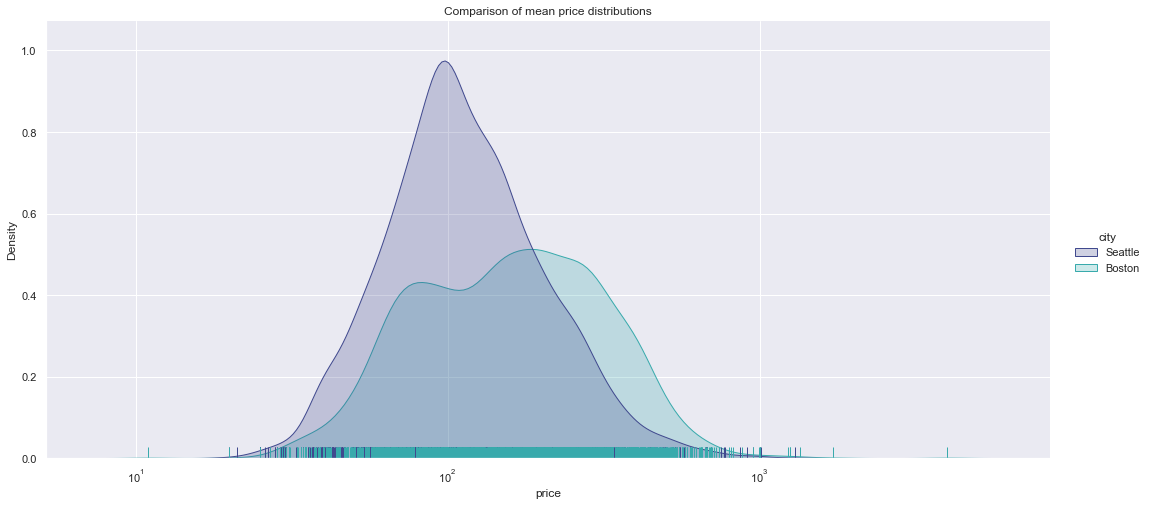

In [26]:
# Calculate the mean listing price for both cities
mean_price_seattle = df_seattle.groupby('listing_id').mean()['price'].to_frame().reset_index()
mean_price_seattle['city'] = 'Seattle'

mean_price_boston = df_boston.groupby('listing_id').mean()['price'].to_frame().reset_index()
mean_price_boston['city'] = 'Boston'

# Plot the probability density function of the mean prices
mean_prices = pd.concat([mean_price_seattle, mean_price_boston])
means_figure = sns.displot(data=mean_prices, x='price', kind='kde', hue='city', log_scale=True,fill=True, palette='mako', height=7, aspect=15/7, rug='True')
means_figure.set(title='Comparison of mean price distributions')
plt.savefig('figures/comparison_means.pdf', bbox_inches='tight')

In [27]:
# Overall mean listing price in Seattle
mean_price_seattle['price'].mean()

135.7640601537379

In [28]:
# Overall mean listing price in Boston
mean_price_boston['price'].mean()

196.9351274354401

In [29]:
# Calculate Mann-Whitney U test of the differences between means in Seattle and Boston
mannwhitneyu(mean_price_seattle['price'].to_list(), mean_price_boston['price'].to_list())

MannwhitneyuResult(statistic=3905616.0, pvalue=1.3978491233744973e-84)

In [30]:
# Get the room type and number of guests to accommodate for each listing, for which we calculated the mean price
means_by_attributes_seattle = pd.merge(mean_price_seattle, df_listing_seattle[['id', 'room_type', 'accommodates']], left_on=['listing_id'], right_on = ['id'])
means_by_attributes_seattle.drop(columns = 'id', inplace=True)
means_by_attributes_seattle['price'] = means_by_attributes_seattle['price'].apply(lambda l: round(l,2))

means_by_attributes_boston = pd.merge(mean_price_boston, df_listing_boston[['id', 'room_type', 'accommodates']], left_on=['listing_id'], right_on = ['id'])
means_by_attributes_boston.drop(columns = 'id', inplace=True)
means_by_attributes_boston['price'] = means_by_attributes_boston['price'].apply(lambda l: round(l,2))

In [31]:
# Calculate the mean price by room type and number of guests to accommodate
grouped_seattle = means_by_attributes_seattle.groupby(['room_type', 'accommodates'])['price'].mean().reset_index(name='mean_price')
grouped_boston = means_by_attributes_boston.groupby(['room_type', 'accommodates'])['price'].mean().reset_index(name='mean_price')

grouped_seattle['city'] = 'Seattle'
grouped_boston['city'] = 'Boston'

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


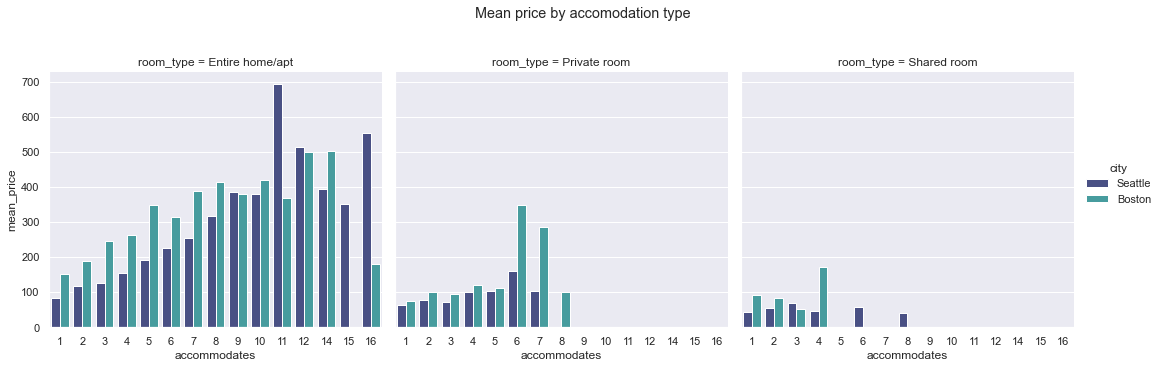

In [32]:
# Plot the price means by room type and number of guests to accommodate
fig_accomodation = sns.factorplot(x="accommodates", y="mean_price", hue="city", col="room_type", data=pd.concat([grouped_seattle, grouped_boston]), kind="bar", palette='mako')
fig_accomodation.fig.subplots_adjust(top=0.8)
fig_accomodation.fig.suptitle('Mean price by accomodation type')
plt.savefig('figures/distribution_means_by_column.pdf', bbox_inches='tight')

In [33]:
# Get list of prices by room type and number of guests to accommodate in both cities
grouped_seattle = means_by_attributes_seattle.groupby(['room_type', 'accommodates'])['price'].apply(list).reset_index(name='values')
grouped_boston = means_by_attributes_boston.groupby(['room_type', 'accommodates'])['price'].apply(list).reset_index(name='values')

# Merge lists of values from both cities based on room type and number of guests to accommodate in both cities
df_diff_attribute = pd.merge(grouped_seattle, grouped_boston, left_on=['room_type', 'accommodates'], right_on = ['room_type', 'accommodates'])

# Calcluate Mann-Whitney U test of the difference of prices between groups of listings based on room type and number of guests to accommodate in both cities
df_diff_attribute['p-value'] = df_diff_attribute.apply(lambda row: round(mannwhitneyu(row['values_x'], row['values_y'])[1],3), axis=1)

# Add the sample size from each group for a better interpretation of the results
df_diff_attribute['sample_size_seattle'] = df_diff_attribute['values_x'].apply(lambda l: len(l))
df_diff_attribute['sample_size_boston'] = df_diff_attribute['values_y'].apply(lambda l: len(l))

# Display and highlicht significant differences between the groups
df_diff_attribute[['room_type', 'accommodates','sample_size_seattle', 'sample_size_boston', 'p-value']].style.apply(highlight_significant, subset=['p-value'], axis=1)

,room_type,accommodates,sample_size_seattle,sample_size_boston,p-value
0,Entire home/apt,1,18,16,0.002000
1,Entire home/apt,2,721,481,0.000000
2,Entire home/apt,3,319,301,0.000000
3,Entire home/apt,4,699,462,0.000000
4,Entire home/apt,5,171,206,0.000000
5,Entire home/apt,6,319,174,0.000000
6,Entire home/apt,7,47,34,0.000000
7,Entire home/apt,8,106,48,0.007000
8,Entire home/apt,9,12,10,0.205000
9,Entire home/apt,10,25,14,0.091000


## 2. Which time of the year is availability highest in both cities?

In [34]:
# Calculate the number of available listings per month and year
# Since price != nan means that a listing is available and since we have dropped all nan price rows, all listings in the remaining dataframe are available
group_bookings_seattle = df_seattle.groupby(['month', 'year'])['listing_id'].count()  #['listing_id'].unique().apply(len)
group_bookings_seattle = group_bookings_seattle.to_frame().rename(columns={'listing_id':'count'})

group_bookings_boston = df_boston.groupby(['month', 'year'])['listing_id'].count() #.unique().apply(len)
group_bookings_boston = group_bookings_boston.to_frame().rename(columns={'listing_id':'count'})

display_side_by_side(group_bookings_seattle,group_bookings_boston,titles=['Seattle','Boston'])

Seattle 
 
 
 
 
 count 
 
 
 month 
 year 
 
 
 
 
 
 1 
 2016 
 59239 
 
 
 2017 
 5698 
 
 
 2 
 2016 
 73321 
 
 
 3 
 2016 
 83938 
 
 
 4 
 2016 
 76037 
 
 
 5 
 2016 
 79971 
 
 
 6 
 2016 
 77244 
 
 
 7 
 2016 
 74222 
 
 
 8 
 2016 
 76347 
 
 
 9 
 2016 
 77246 
 
 
 10 
 2016 
 82438 
 
 
 11 
 2016 
 81780 
 
 
 12 
 2016 
 87061 
 
 
 Boston 
 
 
 
 
 count 
 
 
 month 
 year 
 
 
 
 
 
 1 
 2017 
 63181 
 
 
 2 
 2017 
 56810 
 
 
 3 
 2017 
 55181 
 
 
 4 
 2017 
 51382 
 
 
 5 
 2017 
 53600 
 
 
 6 
 2017 
 52731 
 
 
 7 
 2017 
 54963 
 
 
 8 
 2017 
 55561 
 
 
 9 
 2016 
 24401 
 
 
 2017 
 8997 
 
 
 10 
 2016 
 46345 
 
 
 11 
 2016 
 58888 
 
 
 12 
 2016 
 60997

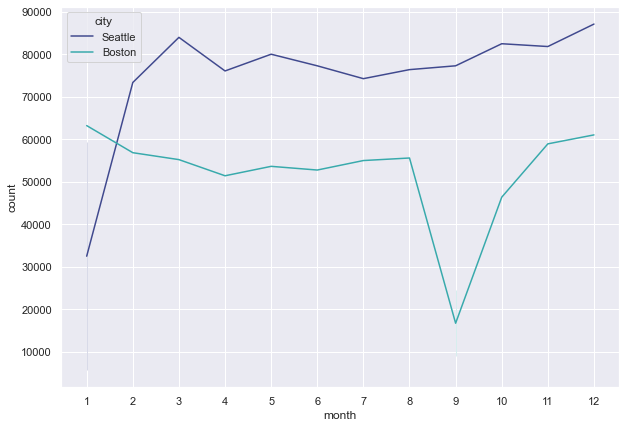

In [35]:
group_bookings_seattle['city'] = 'Seattle'
group_bookings_boston['city'] = 'Boston'

# Plot the number of available listings per month in both cities
sns.set(rc={'figure.figsize':(10,7)})
graph = sns.lineplot(data=pd.concat([group_bookings_seattle, group_bookings_boston]), palette='mako', x='month', y='count', hue='city')
# Set the x-axis labels to month numbers
graph.set_xticks(range(1,13)) 


plt.savefig('figures/available_per_month.pdf', bbox_inches='tight')

In [36]:
# Calculate the percentage of available listings per day
unique_listings_seattle = len(df_seattle['listing_id'].unique())
group_bookings_seattle = df_seattle.groupby(['date'])['listing_id'].unique().apply(len)/unique_listings_seattle
group_bookings_seattle = group_bookings_seattle.to_frame().reset_index().rename(columns={'listing_id':'count'})

unique_listings_boston = len(df_boston['listing_id'].unique())
group_bookings_boston = df_boston.groupby(['date'])['listing_id'].unique().apply(len)/unique_listings_boston
group_bookings_boston = group_bookings_boston.to_frame().reset_index().rename(columns={'listing_id':'count'})

display_side_by_side(group_bookings_seattle,group_bookings_boston,titles=['Seattle','Boston'])

,date,count
0,2016-01-04,0.466022
1,2016-01-05,0.501477
2,2016-01-06,0.490465
3,2016-01-07,0.477035
4,2016-01-08,0.478646
5,2016-01-09,0.498523
6,2016-01-10,0.539619
7,2016-01-11,0.558689
8,2016-01-12,0.567822
9,2016-01-13,0.563255


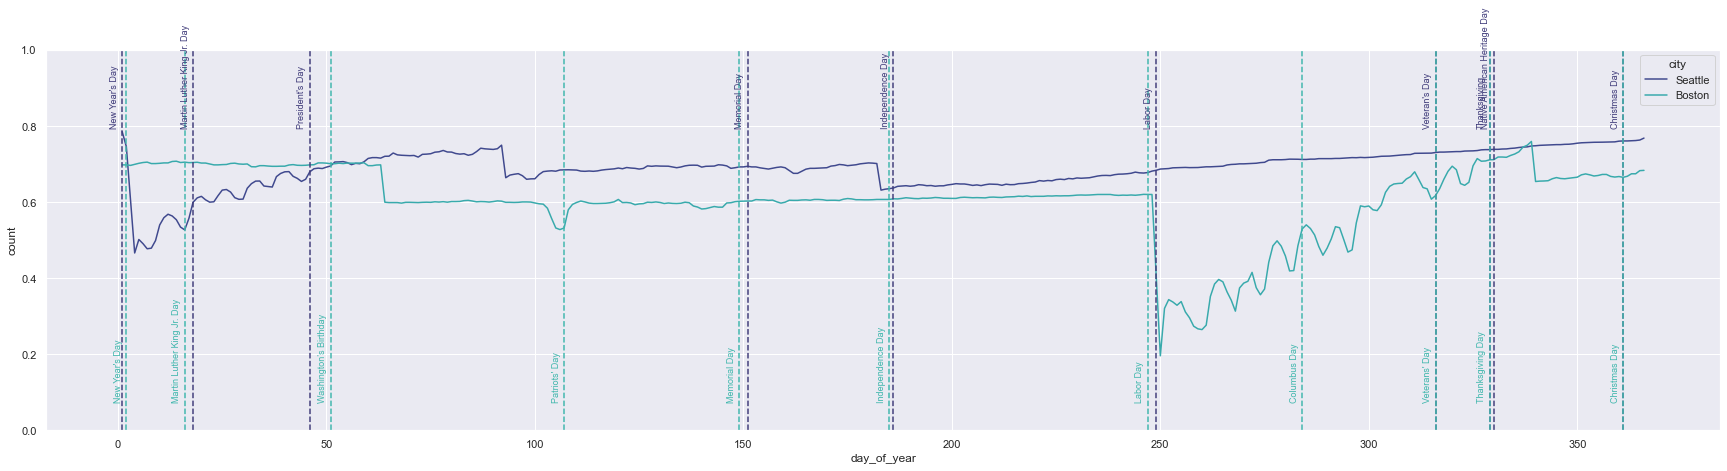

In [37]:
group_bookings_seattle['city'] = 'Seattle'
group_bookings_boston['city'] = 'Boston'

# Plot the percentage of available listings per day of the year
group_bookings_seattle['day_of_year'] = group_bookings_seattle['date'].dt.dayofyear
group_bookings_boston['day_of_year'] = group_bookings_boston['date'].dt.dayofyear

sns.set(rc={'figure.figsize':(30,7)})
graph = sns.lineplot(data=pd.concat([group_bookings_seattle, group_bookings_boston]), palette='mako', x='day_of_year', y='count', hue='city')
graph.set(ylim=(0, 1))

color_seattle = sns.color_palette("mako")[1]
color_boston = sns.color_palette("mako")[4]

# Plot axes of holiday dates in Boston and Seattle
holidays_seattle.apply(lambda row: draw_holiday(row['day_of_year'],row['holiday'], graph, color_seattle, 'top'), axis=1)
holidays_boston.apply(lambda row: draw_holiday(row['day_of_year'],row['holiday'], graph, color_boston, 'bottom'), axis=1)

plt.savefig('figures/availability_day_of_year.pdf', bbox_inches='tight')

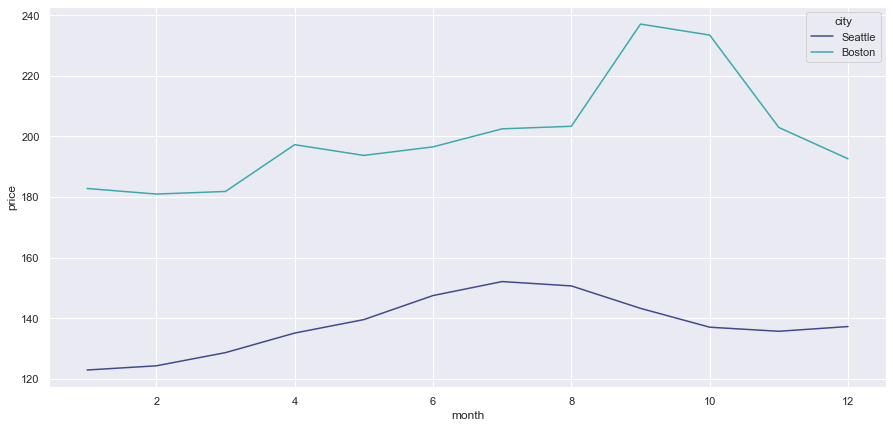

In [38]:
# Calculate and plot mean price by month for each city
mean_price_month_seattle = df_seattle.groupby(['month'])['price'].mean()
mean_price_month_seattle = mean_price_month_seattle.to_frame().reset_index()

mean_price_month_boston = df_boston.groupby(['month'])['price'].mean()
mean_price_month_boston = mean_price_month_boston.to_frame().reset_index()

mean_price_month_seattle['city'] = 'Seattle'
mean_price_month_boston['city'] = 'Boston'


sns.set(rc={'figure.figsize':(15,7)})
graph = sns.lineplot(data=pd.concat([mean_price_month_seattle, mean_price_month_boston]), palette='mako', x='month', y='price', hue='city')
plt.savefig('figures/price_per_month.pdf', bbox_inches='tight')

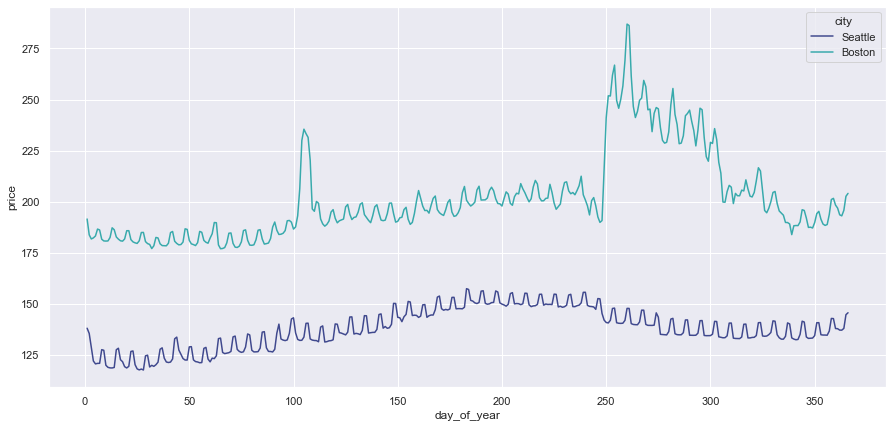

In [39]:
# Calculate and plot mean price by day of the year for each city
mean_price_month_seattle = df_seattle.groupby(['date'])['price'].mean()
mean_price_month_seattle = mean_price_month_seattle.to_frame().reset_index()

mean_price_month_boston = df_boston.groupby(['date'])['price'].mean()
mean_price_month_boston = mean_price_month_boston.to_frame().reset_index()

mean_price_month_seattle['city'] = 'Seattle'
mean_price_month_boston['city'] = 'Boston'

mean_price_month_seattle['day_of_year'] = mean_price_month_seattle['date'].dt.dayofyear
mean_price_month_boston['day_of_year'] = mean_price_month_boston['date'].dt.dayofyear

sns.set(rc={'figure.figsize':(15,7)})
graph = sns.lineplot(data=pd.concat([mean_price_month_seattle, mean_price_month_boston]), palette='mako', x='day_of_year', y='price', hue='city')

plt.savefig('figures/price_day_of_year.pdf', bbox_inches='tight')

## 3. How do neighborhood and amenities correlate with price?

In [40]:
# Get the list of neighborhoods for both cities
neighbourhoods_seattle = df_seattle['neighbourhood'].unique()
neighbourhoods_seattle = [n for n in neighbourhoods_seattle if not pd.isnull(n)]

neighbourhoods_boston = df_boston['neighbourhood'].unique()
neighbourhoods_boston = [n for n in neighbourhoods_boston if not pd.isnull(n)]

In [41]:
# Add binary columns with neoghborhood for each listing
df_neighbourhood_seattle = df_seattle[['listing_id', 'neighbourhood', 'price']]
df_neighbourhood_seattle.dropna(subset=['neighbourhood'], inplace=True)
col_to_binary(df_neighbourhood_seattle, 'neighbourhood', neighbourhoods_seattle)

df_neighbourhood_boston = df_boston[['listing_id', 'neighbourhood', 'price']]
df_neighbourhood_boston.dropna(subset=['neighbourhood'], inplace=True)
col_to_binary(df_neighbourhood_boston, 'neighbourhood', neighbourhoods_boston)

/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/abirbouraffa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

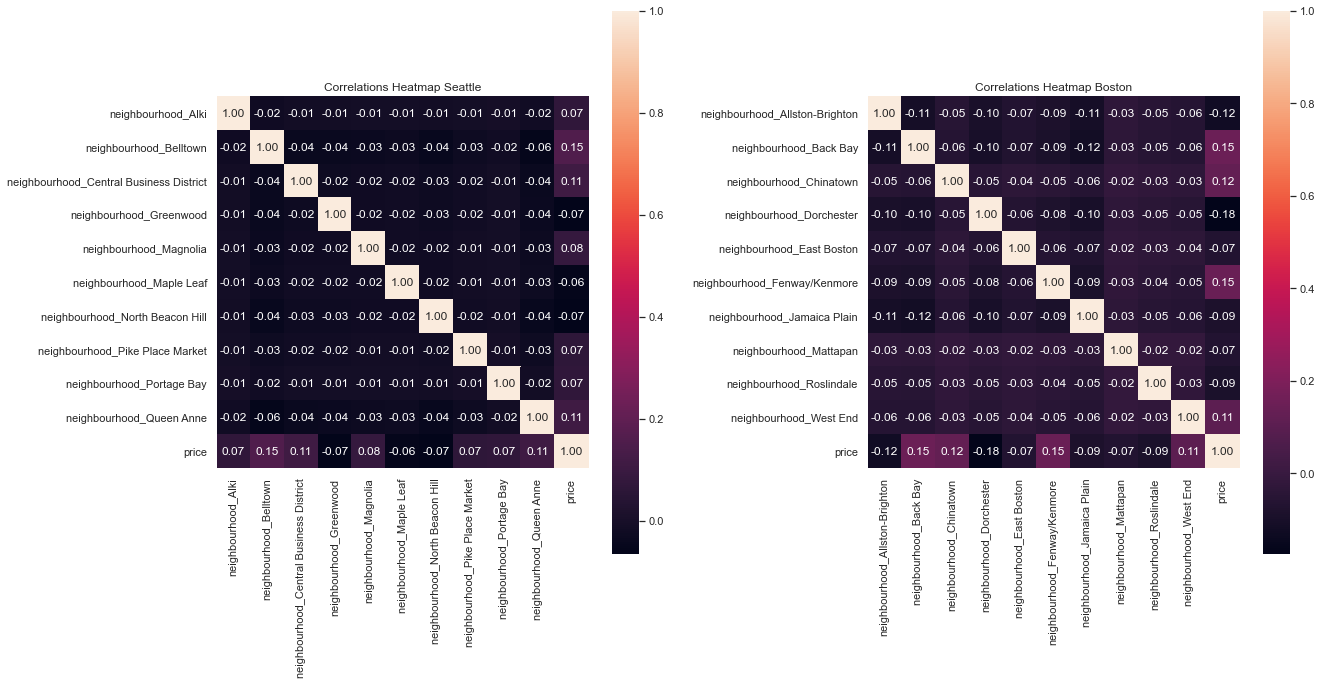

In [42]:
cols_seattle = ['neighbourhood_' + c for c in neighbourhoods_seattle]
cols_boston = ['neighbourhood_' + c for c in neighbourhoods_boston]

# Calculate the top 10 neighborhoods correlating with price
top_neighborhoods_seattle_cols = get_top_corr_columns(10, df_neighbourhood_seattle, ['price'] + cols_seattle)
top_neighborhoods_boston_cols = get_top_corr_columns(10, df_neighbourhood_boston, ['price'] + cols_boston)

# Plot heatmaps of top correlating neighborhoods
corr_seattle = np.corrcoef(df_neighbourhood_seattle[top_neighborhoods_seattle_cols].values.T)
corr_boston = np.corrcoef(df_neighbourhood_boston[top_neighborhoods_boston_cols].values.T)

sns.set(rc={'figure.figsize':(15,15)})
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=3)
sns.set(font_scale=1)


heatmap_seattle = sns.heatmap(corr_seattle, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels =top_neighborhoods_seattle_cols , xticklabels = top_neighborhoods_seattle_cols, ax=ax1).set_title('Correlations Heatmap Seattle')

heatmap_boston = sns.heatmap(corr_boston, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels =top_neighborhoods_boston_cols , xticklabels = top_neighborhoods_boston_cols, ax=ax2).set_title('Correlations Heatmap Boston')

plt.savefig('figures/neighbourhood_correlation_top_10.pdf', bbox_inches='tight')

In [43]:
amenities_seattle = [col for col in df_listing_seattle if col.startswith('has_') and col != 'has_availability']
amenities_boston = [col for col in df_listing_boston if col.startswith('has_') and col != 'has_availability']

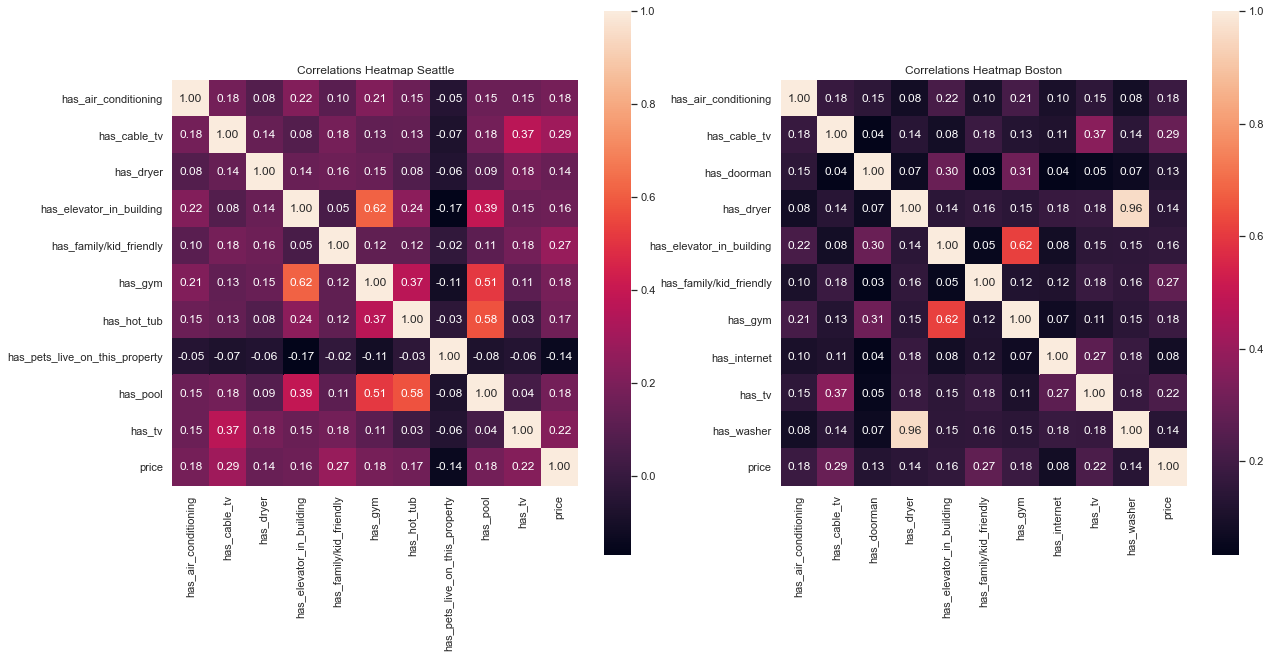

In [44]:
# Calculate the top 10 amenities correlating with price
top_amenities_seattle_cols = get_top_corr_columns(10, df_seattle, ['price'] + amenities_seattle)
top_amenities_boston_cols = get_top_corr_columns(10, df_boston, ['price'] + amenities_boston)

corr_seattle = np.corrcoef(df_seattle[top_amenities_seattle_cols].values.T)
corr_boston = np.corrcoef(df_seattle[top_amenities_boston_cols].values.T)

# Plot heatmaps of top correlating amenities
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))
sns.set(font_scale=1)

heatmap_seattle = sns.heatmap(corr_seattle, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels =top_amenities_seattle_cols , xticklabels = top_amenities_seattle_cols, ax=ax1).set_title('Correlations Heatmap Seattle')

heatmap_boston = sns.heatmap(corr_boston, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels =top_amenities_boston_cols , xticklabels = top_amenities_boston_cols, ax=ax2).set_title('Correlations Heatmap Boston')

plt.savefig('figures/amenities_correlation_top_10.pdf', bbox_inches='tight')